In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [238]:
# Read train and test csv files
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
train_full = pd.read_csv('data/train.csv')
test_full = pd.read_csv('data/test.csv')

# <center>Data Preparation</center>

### Translate year from str to int 

In [186]:
def age_in_days(x):
    if x[1] in 'days': return int(x[0])
    if x[1] in 'weeks': return int(x[0]) * 7
    if x[1] in 'months': return int(x[0]) * 30
    if x[1] in 'years': return int(x[0]) * 365
    else: return int(x[0])

### Get list of unique breeds - without 'Mix' and '/'

In [5]:
def list_breeds(df):
    un = df.Breed.unique()
    tmp = []
    for i in un:
        if 'Mix' in i:
            tmp.append(' '.join(i.split()[:-1]))
        elif '/' in i:
            tmp.append(i.split(sep='/')[0])
            tmp.append(i.split(sep='/')[1])
        else: tmp.append(i)
    return set(tmp)

### Get list of unique colors - without '/'

In [6]:
def list_colors(df):
    colors = set()
    for i in df['Color'].str.replace('/', ' ').tolist():
        for j in i.split():
            colors.add(j)
    return colors

In [74]:
breed_tr = list_breeds(df_train)
breed_test = list_breeds(df_test)
breeds = breed_tr.union(breed_test)

colors = list_colors(df_train)

### *Here was a try to make color groups*

In [102]:
group_color = {'Black': ['Agouti', 'Black','Sable'],
               'Yellow': ['Yellow','Orange','Lynx','Apricot','Buff','Cream','Fawn','Gold', 'Tan', 'Tick'],
               'Red': ['Flame', 'Pink','Red', 'Tiger'], 
               'Grey': ['Blue','Gray','Lilac','Smoke'],
               'Brown': ['Brindle','Brown','Chocolate','Liver','Ruddy', 'Tabby'],
               'Tricolor': ['Calico', 'Torbie', 'Tortie','Tricolor'],
               'White': ['Merle', 'Point','Seal','Silver','White']}

In [100]:
def type_color(color):
    for i, j in group_color.items():
        for k in j:
            if k in color:
                return i
    return 'Black' # if unknown

### Real data Preparation

In [181]:
def data_preparation(df, is_train):
    df['Name'] = df['Name'].isna().apply(lambda x: 0 if x else 1) 
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Year'] = df['DateTime'].map(lambda x: x.year)
    df['Month'] = df['DateTime'].map(lambda x: x.month)
    df['dayOfWeek'] = df['DateTime'].map(lambda x: x.dayofweek)
    
    if is_train:
        df['OutcomeType'] = df['OutcomeType'].map({'Return_to_owner':0, 
                                           'Euthanasia':1, 'Adoption':2, 
                                           'Transfer':3, 'Died':4})
        df = df.drop(['AnimalID','OutcomeSubtype'], axis=1)
    
    df.AnimalType = df.AnimalType.map({'Cat': 0, 'Dog': 1})
    
    top = df['SexuponOutcome'].describe()['top'] # Change 'Unknown' to the most frequent
    nan_indexes = df[df.SexuponOutcome.isnull()].index
    df.loc[nan_indexes, 'SexuponOutcome'] = pd.Series(top, index=nan_indexes)
    df['Is_steril_sex'] = df['SexuponOutcome'].map({'Neutered Male':1, 
                                                 'Spayed Female':1, 'Intact Male':0, 
                                                 'Intact Female':0, 'Unknown':-1})
    df['SexuponOutcome'] = df['SexuponOutcome'].map({'Neutered Male':1, 
                                                 'Spayed Female':0, 'Intact Male':1, 
                                                 'Intact Female':0, 'Unknown':-1})
    
    df['AgeuponOutcome'] = df['AgeuponOutcome'].fillna('0 -1')
    df['AgeuponOutcome'] = df['AgeuponOutcome'].str.split().apply(age_in_days)
    df['AgeType'] = df['AgeuponOutcome'].apply(lambda x: 0 if (x // 365) < 1 else ( 1 if (x // 365) < 5 else 2) )
    #df['Young'] = df['AgeuponOutcome'].apply(lambda x: 1 if (x // 365) <= 1 else 0)
    #df['Adult'] = df['AgeuponOutcome'].apply(lambda x: 1 if (x // 365) > 1 and (x // 365) <= 5 else 0)
    #df['Old'] = df['AgeuponOutcome'].apply(lambda x: 1 if (x // 365) > 5 else 0)
    
    df['Mix'] = df['Breed'].apply(lambda x: 1 if 'Mix' in x else (1 if '/' in x else 0))
    
    for i in breeds:
        df[i] = df.Breed.apply(lambda x: 1 if i in x else 0)
    
    for i in colors:
        df[i] = df.Color.apply(lambda x: 1 if i in x else 0)
    #df.Color = df.Color.apply(lambda x: type_color(x))    
    #for i in group_color.keys():
        #df[i] = df.Color.apply(lambda x: 1 if x == i else 0)
    
    return df.drop(['DateTime', 'Breed', 'Color', 'AgeuponOutcome', 'SexuponOutcome'], axis=1)

### Final dataframes

In [182]:
train = data_preparation(df_train, 1)
test = data_preparation(df_test, 0)
test = test.drop('ID', axis = 1)

# <center>Some vizualizations</center>

## The distribution of amount of cats and dongs

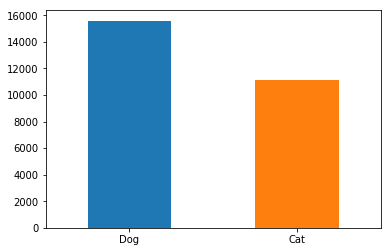

In [209]:
AnimalType = train_full['AnimalType'].value_counts() 
AnimalType.plot(kind='bar',rot=0);

## The distribution of outcome

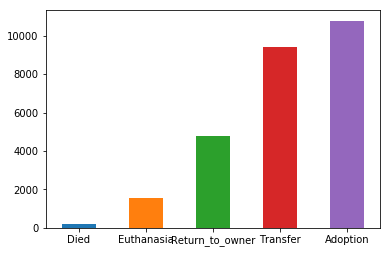

In [223]:
train_full.OutcomeType.value_counts().sort_values().plot(kind='bar',rot=0);

## The destribution of outcomes for each type of animal

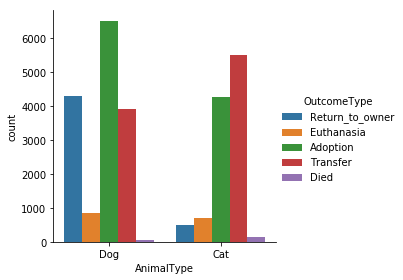

In [226]:
plot = sns.catplot(x="AnimalType", hue="OutcomeType", data=train_full, kind="count", height=4);

## The destribution of outcomes for Sex column

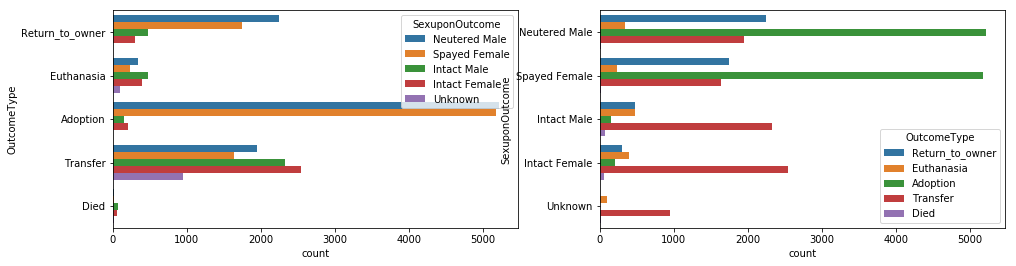

In [227]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(y="OutcomeType",data=train_full,hue="SexuponOutcome", ax=ax1);
sns.countplot(y="SexuponOutcome",data=train_full,hue="OutcomeType", ax=ax2);

## The distribution of days of week for each outcome

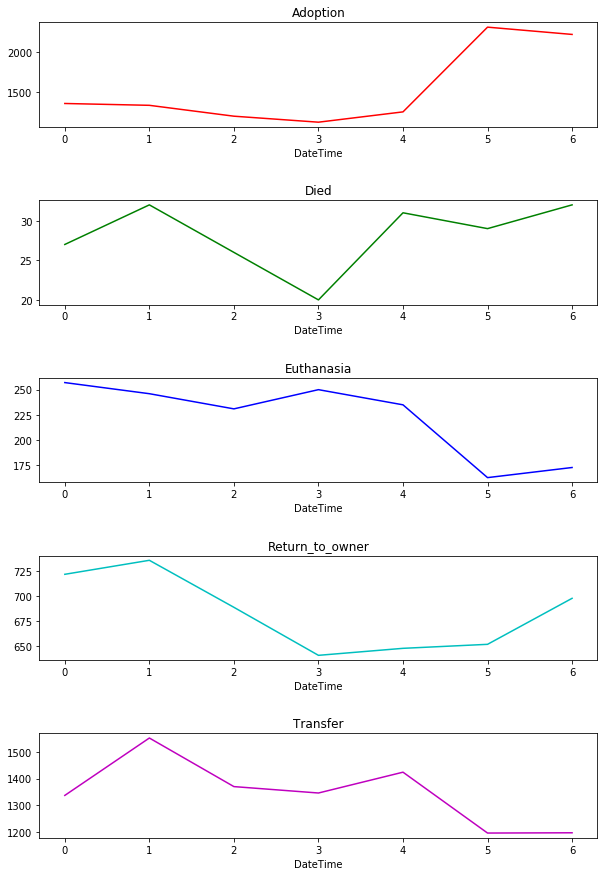

In [231]:
df_dow = pd.to_datetime(train_full.DateTime).dt.dayofweek
dayinweekGroup = train_full["DateTime"].groupby(train_full["OutcomeType"])
plt.subplots(5, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(dayinweekGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_dow).count().plot(kind="line", color=colors[i])

## The distribution of months for each outcome

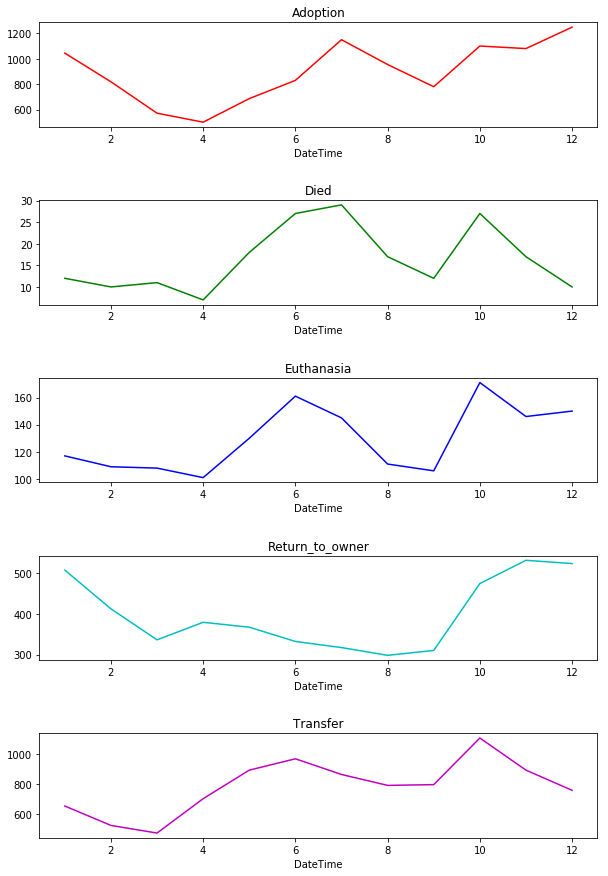

In [232]:
df_dow = pd.to_datetime(train_full.DateTime).dt.month
monthGroup = train_full["DateTime"].groupby(train_full["OutcomeType"])
plt.subplots(5, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(monthGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_dow).count().plot(kind="line", color=colors[i])

## The distribution of ages for each outcome

In [ ]:
train_full['AgeuponOutcome'] = train_full['AgeuponOutcome'].fillna('0 -1')
train_full['AgeuponOutcome'] = train_full['AgeuponOutcome'].str.split().apply(age_in_days)

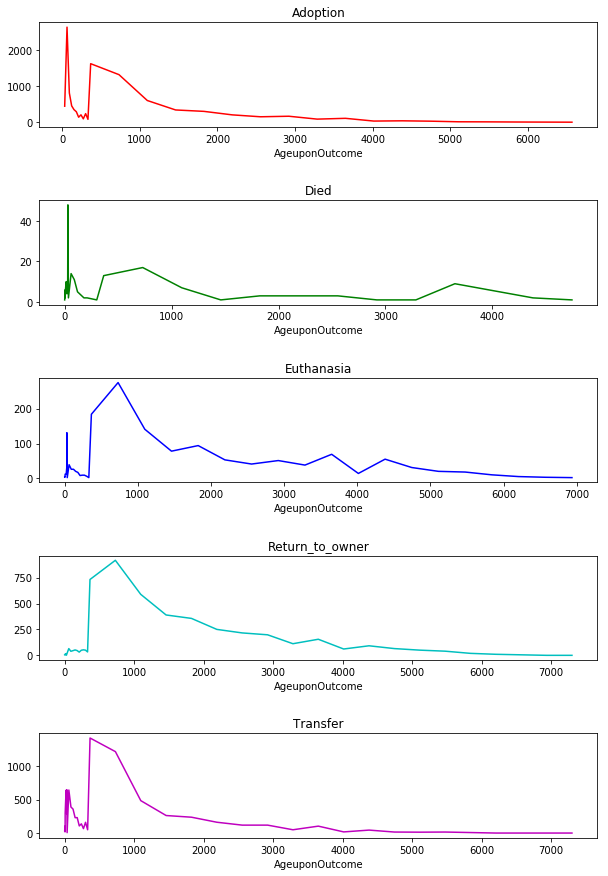

In [243]:
df_dow = train_full['AgeuponOutcome'] 
ageGroup = train_full["AgeuponOutcome"].groupby(train_full["OutcomeType"])
plt.subplots(5, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(ageGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_dow).count().plot(kind="line", color=colors[i])

# <center>Train our models</center>

### Split by train and test

In [183]:
y = train['OutcomeType']
X = train.drop('OutcomeType', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y , test_size=0.7)

### Random Forest

In [184]:
rf = RandomForestClassifier(random_state=42, n_estimators=250, oob_score=True)
rf.fit(X_train,y_train)
print(rf.oob_score_ , log_loss(y_valid, rf.predict_proba(X_valid)))

0.6163631828386131 1.0995639573487637


NB: 
- I noticed that it's not important is it True Blood or not, so we can keep only isMix column.
- Also I tried to divide all colors to some basic colors, but it didn't help to improve our model.
- Thirdly I noticed that age type can't imporove model too. Or I did something wrong.

### Output to CSV file

In [157]:
pred = rf.predict_proba(test)

ypred_submit = pd.DataFrame(pred)
submission = pd.DataFrame()
submission["ID"] = df_test['ID'].values
submission["Adoption"]= ypred_submit[2]
submission["Died"]= ypred_submit[4]
submission["Euthanasia"]= ypred_submit[1]
submission["Return_to_owner"]= ypred_submit[0]
submission["Transfer"]= ypred_submit[3]
submission = pd.DataFrame(submission)

submission.to_csv("submission01.csv",index=False)

### Linear Regression

In [185]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(X_train,y_train)
log_loss(y_valid, logit.predict_proba(X_valid))

0.90551793702753